In [ ]:
# Install Ultralytics (YOLOv8)
!pip install ultralytics -q
import os
import shutil
import random
import yaml
from glob import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

print("Setup Complete. Libraries installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup Complete. Libraries installed.


In [ ]:
import os
import glob
import random
import shutil
import xml.etree.ElementTree as ET

# --- CONFIGURATION ---
# Path to your Input Data (Update these if different)
INPUT_ROOT_IMAGES = "/kaggle/input/pcb-defects/PCB_DATASET/images"      # Folder with image subfolders
INPUT_ROOT_LABELS = "/kaggle/input/pcb-defects/PCB_DATASET/Annotations" # Folder with XML subfolders
OUTPUT_DIR = "/kaggle/working/yolo_dataset"

# Define your classes manually to ensure order consistency
# Make sure these match exactly what is in the <name> tag of your XMLs
CLASSES = ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper'] 

def convert_xml_to_yolo(xml_file, classes):
    """Parses XML and returns YOLO format lines"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Get image dimensions
    size = root.find('size')
    w_img = int(size.find('width').text)
    h_img = int(size.find('height').text)
    
    yolo_lines = []
    
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        
        # Map class name to ID
        if cls_name not in classes:
            continue
        cls_id = classes.index(cls_name)
        
        xmlbox = obj.find('bndbox')
        xmin = float(xmlbox.find('xmin').text)
        xmax = float(xmlbox.find('xmax').text)
        ymin = float(xmlbox.find('ymin').text)
        ymax = float(xmlbox.find('ymax').text)
        
        # Convert to YOLO (Normalized Center X, Center Y, Width, Height)
        x_center = ((xmin + xmax) / 2) / w_img
        y_center = ((ymin + ymax) / 2) / h_img
        width = (xmax - xmin) / w_img
        height = (ymax - ymin) / h_img
        
        # Format: class_id x_center y_center width height
        yolo_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
    return yolo_lines

def prepare_dataset():
    print("--- STARTING XML TO YOLO CONVERSION ---")
    
    # Create Directories
    for split in ['train', 'val']:
        os.makedirs(f"{OUTPUT_DIR}/{split}/images", exist_ok=True)
        os.makedirs(f"{OUTPUT_DIR}/{split}/labels", exist_ok=True)

    # Get all XML files from input
    # We recursively search because they are in subfolders
    xml_files = glob.glob(f"{INPUT_ROOT_LABELS}/**/*.xml", recursive=True)
    print(f"Found {len(xml_files)} XML files.")
    
    random.shuffle(xml_files)
    
    # Split 80/20
    split_idx = int(len(xml_files) * 0.8)
    train_files = xml_files[:split_idx]
    val_files = xml_files[split_idx:]
    
    def process_batch(files, split_name):
        count = 0
        for xml_path in files:
            # 1. Convert XML to YOLO Text
            try:
                yolo_lines = convert_xml_to_yolo(xml_path, CLASSES)
                if not yolo_lines: continue # Skip if no objects found
                
                # Get the filename (e.g., "01_missing_hole_01")
                basename = os.path.splitext(os.path.basename(xml_path))[0]
                
                # 2. Find the corresponding Image
                # We search for the image in the images folder
                # We try jpg, png, jpeg
                found_img = False
                for ext in ['.jpg', '.JPG', '.png', '.jpeg']:
                    # Construct potential image path
                    # We assume image is in a folder with same name as parent of xml?
                    # Or just search recursively for the image name
                    potential_img = f"{INPUT_ROOT_IMAGES}/**/{basename}{ext}"
                    matches = glob.glob(potential_img, recursive=True)
                    
                    if matches:
                        src_img = matches[0]
                        dst_img = f"{OUTPUT_DIR}/{split_name}/images/{basename}{ext}"
                        dst_txt = f"{OUTPUT_DIR}/{split_name}/labels/{basename}.txt"
                        
                        # Copy Image
                        shutil.copy(src_img, dst_img)
                        
                        # Write Label
                        with open(dst_txt, 'w') as f:
                            f.write('\n'.join(yolo_lines))
                            
                        found_img = True
                        count += 1
                        break
                
                if not found_img:
                    print(f"Warning: Image not found for {basename}")

            except Exception as e:
                print(f"Error processing {xml_path}: {e}")

        print(f"Processed {count} images for {split_name}.")

    process_batch(train_files, 'train')
    process_batch(val_files, 'val')
    
    # Generate data.yaml
    yaml_content = f"""
    path: {OUTPUT_DIR}
    train: train/images
    val: val/images
    nc: {len(CLASSES)}
    names: {CLASSES}
    """
    with open(f"{OUTPUT_DIR}/data.yaml", 'w') as f:
        f.write(yaml_content)
        
    print("\nDataset ready for YOLOv8 Training!")

# RUN THE FUNCTION
prepare_dataset()

--- STARTING XML TO YOLO CONVERSION ---
Found 693 XML files.
Processed 554 images for train.
Processed 139 images for val.

Dataset ready for YOLOv8 Training!


In [ ]:
yaml_content = f"""
path: {OUTPUT_DIR}
train: train/images
val: val/images

nc: {len(CLASSES)}
names: {CLASSES}
"""

with open(f"{OUTPUT_DIR}/data.yaml", 'w') as f:
    f.write(yaml_content)

print("data.yaml created.")

data.yaml created.


In [ ]:
import os
import cv2
import glob

def sanitize_dataset(root_dir):
    print(f"Checking dataset at {root_dir} for corrupt images...")
    
    # We only need to check the 'images' folders
    image_dirs = [
        os.path.join(root_dir, 'train', 'images'),
        os.path.join(root_dir, 'val', 'images')
    ]
    
    removed_count = 0
    
    for img_dir in image_dirs:
        if not os.path.exists(img_dir):
            print(f"Skipping {img_dir} (not found)")
            continue
            
        # Get all files in the directory
        files = os.listdir(img_dir)
        
        for file in files:
            file_path = os.path.join(img_dir, file)
            
            # 1. Skip and remove hidden .ipynb_checkpoints directories/files
            if ".ipynb_checkpoints" in file:
                if os.path.isdir(file_path):
                    import shutil
                    shutil.rmtree(file_path)
                else:
                    os.remove(file_path)
                print(f"Removed hidden system file: {file}")
                continue

            # 2. Check if file is a valid image using OpenCV
            try:
                img = cv2.imread(file_path)
                if img is None:
                    raise ValueError("Image is None")
            except Exception as e:
                # If OpenCV cannot read it, it's corrupt. Delete it.
                print(f"Found corrupt image: {file} - Removing...")
                os.remove(file_path)
                
                # Also try to remove the corresponding label file if it exists
                label_path = file_path.replace("images", "labels").rsplit('.', 1)[0] + ".txt"
                if os.path.exists(label_path):
                    os.remove(label_path)
                
                removed_count += 1

    print(f"\nSanitization complete. Removed {removed_count} corrupt/bad files.")

# Run the sanitization on your dataset folder
sanitize_dataset("/kaggle/working/yolo_dataset")

Checking dataset at /kaggle/working/yolo_dataset for corrupt images...

Sanitization complete. Removed 0 corrupt/bad files.


In [ ]:
model = YOLO('yolov8n.pt') # Load pretrained model

# Train
results = model.train(
    data=f"{OUTPUT_DIR}/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    name='pcb_defect_model'
)

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_defect_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe


image 1/1 /kaggle/working/yolo_dataset/val/images/01_missing_hole_01.jpg: 352x640 3 missing_holes, 42.6ms
Speed: 1.9ms preprocess, 42.6ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
ID    Type            Center (x,y)         Severity   Conf      
----------------------------------------------------------------------
0     missing_hole    (1764, 825)      CRITICAL   0.82
1     missing_hole    (2494, 1297)      CRITICAL   0.80
2     missing_hole    (1646, 365)      MINOR      0.57


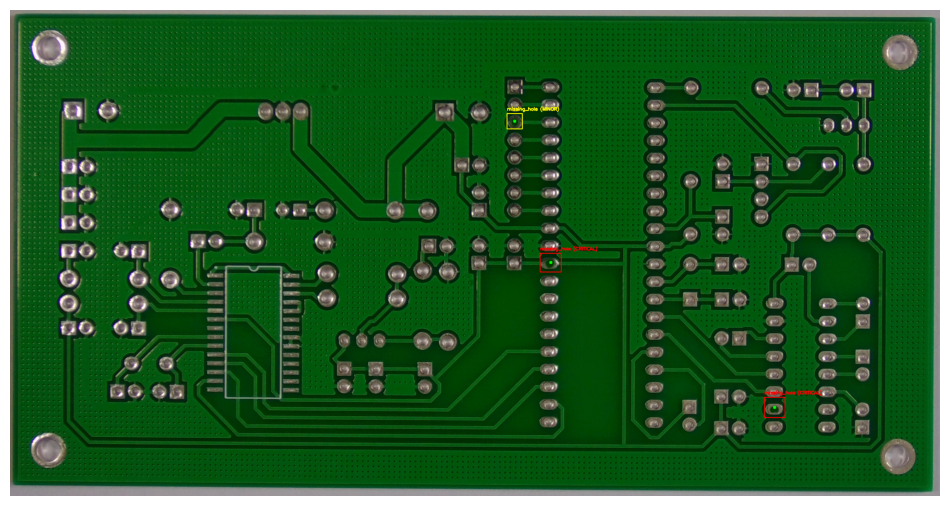


Annotated image saved to /kaggle/working/annotated_sample.jpg (Download this for GitHub)


In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob

# 1. Setup
best_model_path = "/kaggle/working/runs/detect/pcb_defect_model/weights/best.pt"
best_model = YOLO(best_model_path)

# Pick a random image from validation set for the demo
val_images = glob.glob(f"{OUTPUT_DIR}/val/images/*")
test_img_path = random.choice(val_images)

# --- REQ 1 & 2: Analyze Image & Detect Regions ---
results = best_model.predict(test_img_path, conf=0.25)
result = results[0]

# Prepare image for drawing (OpenCV uses BGR, Matplotlib uses RGB)
img_bgr = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h_img, w_img, _ = img_rgb.shape

print(f"{'ID':<5} {'Type':<15} {'Center (x,y)':<20} {'Severity':<10} {'Conf':<10}")
print("-" * 70)

# --- REQ 3 & 4: Classify, Coordinates, & Severity ---
for i, box in enumerate(result.boxes):
    # Extract Coordinates
    x1, y1, x2, y2 = box.xyxy[0].tolist() # Bounding box
    w_box = x2 - x1
    h_box = y2 - y1
    
    # Calculate Center
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    # Extract Class and Confidence
    cls_id = int(box.cls[0])
    label = result.names[cls_id]
    conf = float(box.conf[0])
    
    # --- SEVERITY LOGIC (Heuristic) ---
    # Example logic: If defect is > 10% of image width OR confidence > 0.8, it's CRITICAL
    if w_box > (w_img * 0.10) or conf > 0.8:
        severity = "CRITICAL"
        color = (255, 0, 0) # Red for critical
    elif w_box > (w_img * 0.05):
        severity = "MODERATE"
        color = (255, 165, 0) # Orange
    else:
        severity = "MINOR"
        color = (255, 255, 0) # Yellow

    # Print Data Table
    print(f"{i:<5} {label:<15} ({center_x}, {center_y}){'':<5} {severity:<10} {conf:.2f}")

    # Draw on Image (Annotation)
    # Box
    cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    # Center Point
    cv2.circle(img_rgb, (center_x, center_y), 5, (0, 255, 0), -1)
    # Label
    caption = f"{label} ({severity})"
    cv2.putText(img_rgb, caption, (int(x1), int(y1)-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Show Final Image
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Save for GitHub (Requirement 4b)
out_path = "/kaggle/working/annotated_sample.jpg"
cv2.imwrite(out_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
print(f"\nAnnotated image saved to {out_path} (Download this for GitHub)")

--- Generating Defective Samples ---

0: 544x640 1 mouse_bite, 3 spurs, 42.1ms
Speed: 3.1ms preprocess, 42.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)
Saved: defect_sample_1.jpg


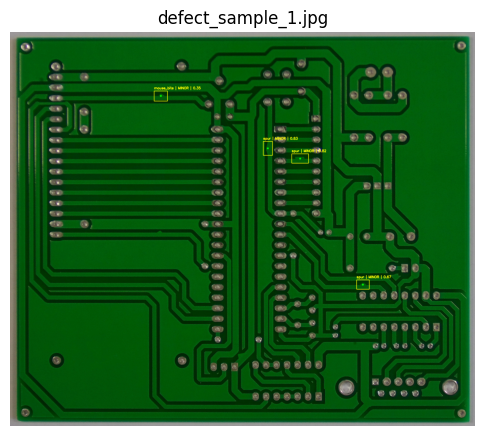


0: 544x640 3 missing_holes, 6.0ms
Speed: 3.0ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)
Saved: defect_sample_2.jpg


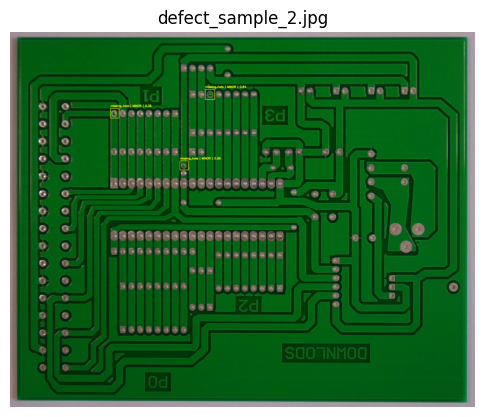


0: 512x640 4 spurs, 42.0ms
Speed: 3.0ms preprocess, 42.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
Saved: defect_sample_3.jpg


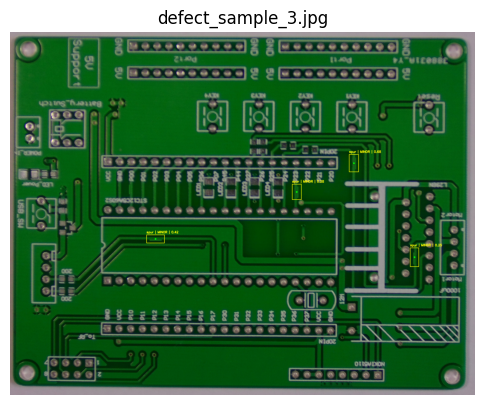


0: 544x640 3 spurious_coppers, 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
Saved: defect_sample_4.jpg


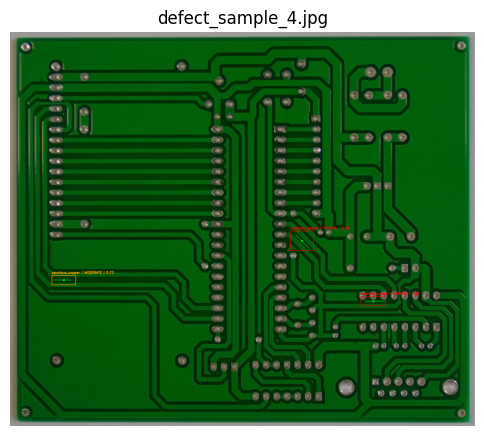


--- Generating Non-Defective Sample ---

0: 352x640 2 missing_holes, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Saved: defect_free_sample.jpg


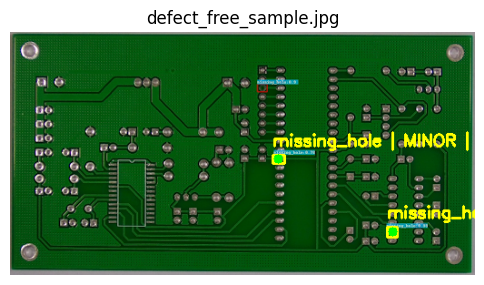


--- Zipping Files ---
SUCCESS! Download 'github_submission_images.zip' from the Output tab.


In [ ]:
import os
import cv2
import glob
import random
import requests
import numpy as np
import shutil
import zipfile
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- SETUP ---
OUTPUT_DIR = "/kaggle/working/github_submission"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR) # Clean up old runs
os.makedirs(OUTPUT_DIR)

# Load Model
model = YOLO("/kaggle/working/runs/detect/pcb_defect_model/weights/best.pt")

# --- HELPER FUNCTION: ANALYZE & SAVE ---
def process_and_save(img_array, filename, is_clean_test=False):
    # 1. Run Prediction
    # Lower confidence for clean test to prove it doesn't hallucinate
    conf_thresh = 0.15 if is_clean_test else 0.25
    results = model.predict(img_array, conf=conf_thresh)
    result = results[0]

    # 2. Setup visualization
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    h_img, w_img, _ = img_rgb.shape
    
    # 3. Draw Annotations
    detected = False
    
    if len(result.boxes) == 0 and is_clean_test:
        # Perfect Result for Clean Test
        cv2.putText(img_rgb, "PASS: NO DEFECTS FOUND", (50, 80), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    
    for box in result.boxes:
        detected = True
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        w_box = x2 - x1
        
        # Coordinates
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        
        # Class & Conf
        cls_id = int(box.cls[0])
        label = result.names[cls_id]
        conf = float(box.conf[0])

        # Severity Assessment
        if w_box > (w_img * 0.15) or conf > 0.85:
            severity = "CRITICAL"
            color = (255, 0, 0) # Red
        elif w_box > (w_img * 0.05):
            severity = "MODERATE"
            color = (255, 165, 0) # Orange
        else:
            severity = "MINOR"
            color = (255, 255, 0) # Yellow
            
        # Draw Box
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        # Draw Center
        cv2.circle(img_rgb, (center_x, center_y), 5, (0, 255, 0), -1)
        # Draw Label
        label_text = f"{label} | {severity} | {conf:.2f}"
        cv2.putText(img_rgb, label_text, (int(x1), int(y1)-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # 4. Save Image
    save_path = os.path.join(OUTPUT_DIR, filename)
    cv2.imwrite(save_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    print(f"Saved: {filename}")
    
    # Optional: Show in Notebook
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(filename)
    plt.show()

# --- STEP 1: GENERATE 4 DEFECTIVE SAMPLES ---
print("--- Generating Defective Samples ---")
val_images = glob.glob("/kaggle/working/yolo_dataset/val/images/*")

if len(val_images) >= 4:
    selected_files = random.sample(val_images, 4)
else:
    selected_files = val_images # Take whatever we have if less than 4

for i, img_path in enumerate(selected_files):
    img = cv2.imread(img_path)
    process_and_save(img, f"defect_sample_{i+1}.jpg")

# --- STEP 2: GENERATE 1 DEFECT-FREE SAMPLE ---
print("\n--- Generating Non-Defective Sample ---")
url = "https://user-images.githubusercontent.com/59477814/130058005-02531758-5d4f-47f9-bd61-749155690dab.png"
try:
    response = requests.get(url)
    img_array = np.asarray(bytearray(response.content), dtype="uint8")
    clean_img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    process_and_save(clean_img, "defect_free_sample.jpg", is_clean_test=True)
except Exception as e:
    print(f"Could not download clean sample: {e}")

# --- STEP 3: ZIP FOR DOWNLOAD ---
print("\n--- Zipping Files ---")
shutil.make_archive("/kaggle/working/github_submission_images", 'zip', OUTPUT_DIR)
print("SUCCESS! Download 'github_submission_images.zip' from the Output tab.")

In [ ]:
!zip -r output_files.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/github_submission/ (stored 0%)
  adding: kaggle/working/github_submission/defect_sample_2.jpg (deflated 2%)
  adding: kaggle/working/github_submission/defect_sample_4.jpg (deflated 2%)
  adding: kaggle/working/github_submission/defect_sample_1.jpg (deflated 2%)
  adding: kaggle/working/github_submission/defect_sample_3.jpg (deflated 2%)
  adding: kaggle/working/github_submission/defect_free_sample.jpg (deflated 1%)
  adding: kaggle/working/yolo_dataset/ (stored 0%)
  adding: kaggle/working/yolo_dataset/data.yaml (deflated 26%)
  adding: kaggle/working/yolo_dataset/train/ (stored 0%)
  adding: kaggle/working/yolo_dataset/train/labels.cache (deflated 75%)
  adding: kaggle/working/yolo_dataset/train/images/ (stored 0%)
  adding: kaggle/working/yolo_dataset/train/images/11_short_08.jpg (deflated 1%)
  adding: kaggle/working/yolo_dataset/train/images/09_missing_hole_03.jpg (deflated 1%)
  adding: kaggle/working/yolo_dataset/trai

In [ ]:
from IPython.display import FileLink
import os

# Check if the file exists first
zip_path = "output_files.zip"

if os.path.exists(zip_path):
    print("Click the link below to download:")
    display(FileLink(zip_path))
else:
    print("Error: Zip file not found. Did the previous cell run successfully?")

Click the link below to download:


/kaggle/working/output_files.zip